In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pws_library import get_data, cointegration_test
import statsmodels.tsa.stattools as ts

In [3]:
rollover_dates = ['5/24/2010',
    '3/7/2011',
    '7/6/2012',
    '12/24/2012',
    '1/2/2014',
    '7/1/2015',
    '3/30/2016',
    '1/24/2017',
    '2/7/2018',
    '3/15/2019',
    '3/6/2020',
    '5/25/2021',
    '12/22/2021',
    '4/2/2010',
    '9/8/2010',
    '5/17/2011',
    '4/16/2012',
    '6/25/2013',
    '3/24/2014',
    '4/30/2015',
    '4/1/2016',
    '8/8/2017',
    '4/25/2018',
    '4/16/2019',
    '9/2/2020',
    '3/24/2021',
    '6/15/2022',
    '4/2/2010',
    '11/5/2010',
    '9/20/2011',
    '6/21/2012',
    '9/11/2013',
    '6/24/2014',
    '8/21/2015',
    '8/4/2016',
    '12/15/2017',
    '7/16/2018',
    '7/16/2019',
    '12/17/2020',
    '6/20/2021',
    '9/26/2022',
    '4/11/2010',
    '11/23/2010',
    '12/19/2011',
    '12/6/2012',
    '11/25/2013',
    '9/22/2014',
    '10/21/2015',
    '9/22/2016',
    '9/18/2017',
    '11/19/2018',
    '12/2/2019',
    '12/18/2020',
    '10/1/2021',
    '12/2/2022',]
rollovers = []
for rollover_date in rollover_dates:
    rollovers.append(pd.Timestamp(rollover_date))

In [4]:
df1 = pd.read_csv("C:\\Users\\Bram\\Desktop\\profielwerkstuk\\data\\NQ.csv")
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.set_index('date')
nq = df1['close']

In [5]:
nq.tail()

date
2017-09-20    5978.50
2017-09-21    5945.25
2017-09-22    5935.75
2017-09-25    5876.50
2017-09-26    5892.50
Name: close, dtype: float64

In [6]:
df = get_data(['NDX'], start='2010-01-01', end='2015-01-01')
df['NQ'] = nq
df = df.dropna()
df.head()

[*********************100%***********************]  1 of 1 completed


,NDX,NQ
2010-01-04 00:00:00,1886.699951,1886.75
2010-01-05 00:00:00,1888.430054,1885.25
2010-01-06 00:00:00,1878.420044,1878.50
2010-01-07 00:00:00,1876.719971,1877.50
2010-01-08 00:00:00,1892.589966,1890.00


In [7]:
def cointegration_test(ticker1, ticker2, df):
    
    order1 = {"dep":ticker1, "indep":ticker2}
    order2 = {"dep":ticker2, "indep":ticker1}
    
    for order in [order1, order2]:
        #bereken beta
        y = df[order['dep']].tolist()
        x = df[order['indep']].tolist()

        x = sm.add_constant(x)

        results = sm.OLS(y, x).fit()
        order['beta'] = results.params[1]
        print(f"beta:{order['beta']}")
        order['alpha'] = results.params[0]
        print(f"alpha:{order['alpha']}")
        
        #adfuller test op spread
        spread = df[order['dep']] - order['beta']*df[order['indep']]
        adf = ts.adfuller(spread)
        order['p-value'] = adf[1]
        print(order['p-value'])
        
        #bereken halflife
        df3 = pd.DataFrame(spread, columns=['spread'])
        df3['spread_shift'] = df3['spread'].shift()
        df3['dspread'] = df3['spread'] - df3['spread_shift']
        df3 = df3.dropna()
        
        y3 = df3['dspread'].tolist()
        x3 = df3['spread_shift'].tolist()

        x3 = sm.add_constant(x3)

        results3 = sm.OLS(y3, x3).fit()
        halflife = -np.log(2)/results3.params[1]
        order['halflife'] = halflife
        print(halflife)
        
        
    if order1['p-value'] < 0.05 and order2['p-value'] < 0.05:
        if order1['p-value'] < order2['p-value']:
            return order1
        else:
            return order2
    else:
        print("not both good cointegration")

In [8]:
cointegration_test('NDX', 'NQ', df)

beta:1.0013922696075346
alpha:0.3449759153469998
2.8983315378290377e-11
0.972658856208803
beta:0.9985637862525234
alpha:-0.21799043743860835
2.855375904732314e-11
0.9726866281686893


{'dep': 'NQ',
 'indep': 'NDX',
 'beta': 0.9985637862525234,
 'alpha': -0.21799043743860835,
 'p-value': 2.855375904732314e-11,
 'halflife': 0.9726866281686893}

<AxesSubplot:>

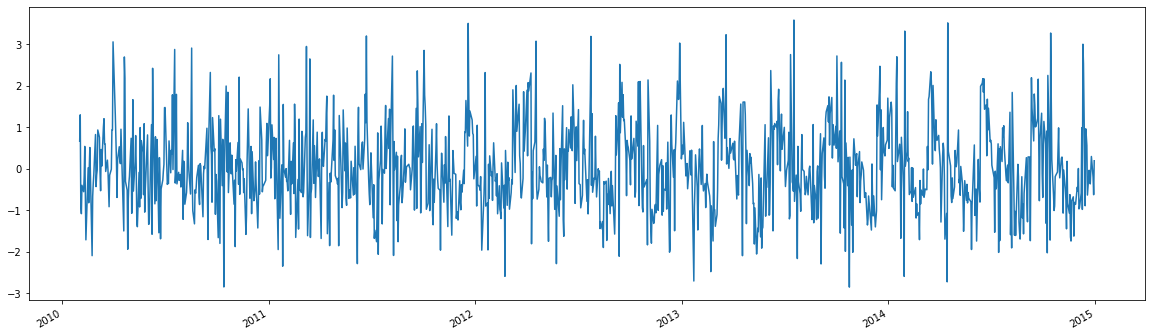

In [9]:
lookback = 20

df['spread'] = df['NDX'] - df['NQ']
df['zscore'] = (df['spread'] - df['spread'].rolling(lookback).mean()) / df['spread'].rolling(lookback).std()
df.dropna(inplace=True)
df['zscore'].plot(figsize=(20,6))

In [10]:
entryZscore = 2
exitZscore = 0


conditions = [(df.zscore < -entryZscore), (df.zscore >= -exitZscore)]
choices = [1, 0]
df['num_long'] = np.select(conditions, choices, default=np.NaN)

conditions1 = [(df.zscore > entryZscore), (df.zscore <= exitZscore)]
choices1 = [-1, 0]
df['num_short'] = np.select(conditions1, choices1, default=np.NaN)

df['num_short'] = df['num_short'].fillna(method='ffill', inplace=False).fillna(value=0, inplace=False)
df['num_long'] = df['num_long'].fillna(method='ffill', inplace=False).fillna(value=0, inplace=False)
df['num_units'] = df['num_long'] + df['num_short']

trades=0
long_pos=False
short_pos=False
for index, row in df.iterrows():
    if not long_pos and row['num_units'] == 1:
        long_pos = True
        short_pos = False
        trades += 1
    if not short_pos and row['num_units'] == -1:
        short_pos = True
        long_pos = False
        trades += 1
    if long_pos or short_pos and row['num_units'] == 0:
        short_pos= False
        long_pos= False

df[f"NDX_pos"] = df['num_units'] * df['NDX']
df[f"NQ_pos"] = -df['num_units'] * df['NQ']
df.head()

,NDX,NQ,spread,zscore,num_long,num_short,num_units,NDX_pos,NQ_pos
2010-02-01 00:00:00,1760.719971,1755.75,4.969971,0.662767,0.0,0.0,0.0,0.0,-0.0
2010-02-02 00:00:00,1776.920044,1769.00,7.920044,1.298322,0.0,0.0,0.0,0.0,-0.0
2010-02-03 00:00:00,1784.699951,1785.50,-0.800049,-0.882834,0.0,0.0,0.0,0.0,-0.0
2010-02-04 00:00:00,1732.989990,1734.75,-1.760010,-1.082548,0.0,0.0,0.0,0.0,-0.0
2010-02-05 00:00:00,1746.119995,1745.00,1.119995,-0.398774,0.0,0.0,0.0,0.0,-0.0


In [11]:
mask = []
for value in df.index.tolist():
    mask.append(value in rollovers)


C:\Users\Bram\AppData\Local\Temp\ipykernel_18140\3506771268.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask]['pnl'] = 0


<AxesSubplot:>

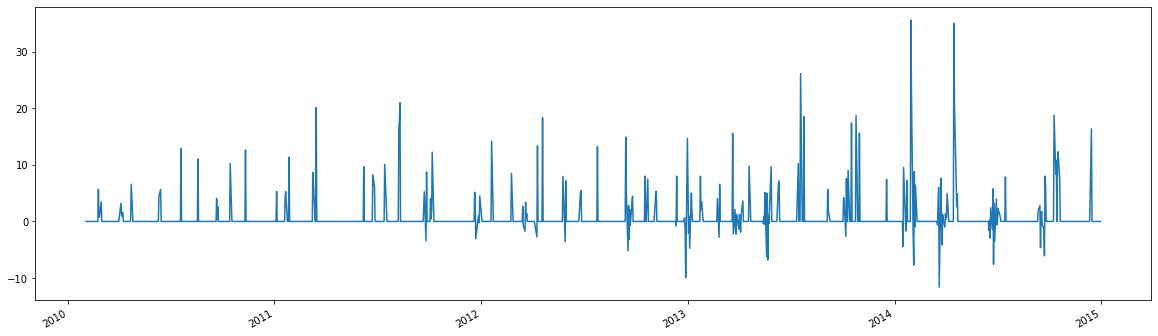

In [12]:
df[f'NDX_pnl'] = (df['NDX']-df['NDX'].shift())/df['NDX'].shift()*df[f'NDX_pos'].shift()
df[f'NQ_pnl'] = (df['NQ']-df['NQ'].shift())/df['NQ'].shift()*df[f'NQ_pos'].shift()


df['pnl'] = df[f'NQ_pnl'] + df[f'NDX_pnl']
df.loc[mask]['pnl'] = 0

df['pnl'].plot(figsize=(20,6))

<AxesSubplot:>

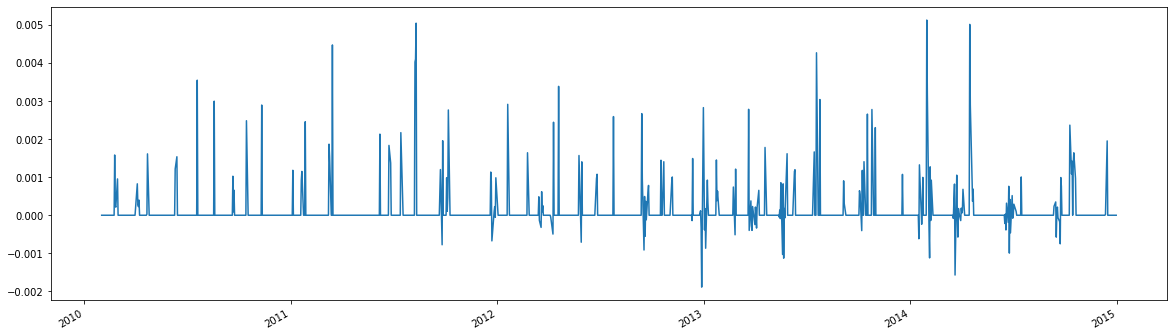

In [13]:
ret = df['pnl'] / (np.abs(df[f'NDX_pos'].shift()) + np.abs(df[f'NQ_pos'].shift()))
ret = ret.fillna(0)
returns_df = pd.DataFrame(ret, columns=['ret'])
returns_df['ret'].plot(figsize=(20,6))

In [14]:
cum_ret = []
for i in range(len(ret)):
    if i == 0:
        cum_ret.append(ret.iloc[i])
    else:
        cum_ret.append((ret.iloc[i] + 1) * (cum_ret[i-1]+1) - 1)


returns_df['cum_ret'] = cum_ret

<AxesSubplot:>

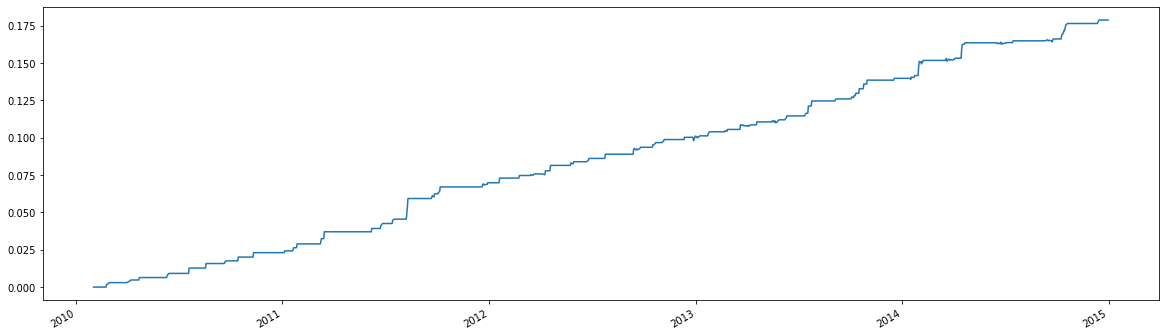

In [15]:
returns_df['cum_ret'].plot(figsize=(20,6))

In [16]:
sharpe = (returns_df['ret'].mean() - (10**(np.log10(1.02570)/365)-1))/returns_df['ret'].std()

In [17]:
returns_df['ret'].mean()

0.00013294599877225444

In [18]:
returns_df['ret'].std()

0.0005824937031828661

In [19]:
(10**(np.log10(1.02570)/365))

1.0000695238038766

In [20]:
print(sharpe)

0.10888048153844457


In [21]:
1.0257**(1/365)

1.0000695238038766

In [25]:
max_drawdown = 0
for i in range(len(returns_df['cum_ret'])):
    current_cumret = returns_df.iloc[i]['cum_ret']
    dd = (current_cumret - returns_df.iloc[:i+1]['cum_ret'].max())/(returns_df.iloc[:i+1]['cum_ret'].max()+1)
    if dd < max_drawdown:
        max_drawdown = dd

In [24]:
returns_df.iloc[:50]['cum_ret'].max()

0.004742585924311982

In [26]:
print(max_drawdown)

-0.0022212103166774637
